In [1]:
import pandas as pd
from IPython.display import display_html
import seaborn as sns
import matplotlib.pyplot as plt

COUNTRIES = ['ENG', 'FRA', 'GER', 'ITA', 'SPA']

In [2]:
actual_dfs = {}

for country in COUNTRIES:
    actual_dfs[country] = pd.read_csv(f'./data/machine_learning/tables/{country}_2023.csv')

In [3]:
# Display tables side by side
def display_side_by_side(*args, spacing=10):
    html_str = ''
    for df in args:
        html_str += df.to_html()
        html_str += '<span style="margin-right: {}px;"></span>'.format(spacing)
    display_html(html_str.replace('table','table style="display:inline"'), raw=True)

In [4]:
# HELPER FUNCTIONS
def assign_points_and_outcome(row):
    if row['home_predicted_result'] == 'W':
        return pd.Series([3, 0, 'W', 'L']) # home win
    elif row['home_predicted_result'] == 'L':
        return pd.Series([0, 3, 'L', 'W'])  # home loss
    else:
        return pd.Series([1, 1, 'D', 'D'])  # draw
    
def count_results(series, result):
    return (series == result).sum()

def outcome_count(series):
    return pd.Series({'W': (series == 'W').sum(), 'D': (series == 'D').sum(), 'L': (series == 'L').sum()})

In [5]:
def print_all_tables_for_model(model):
    df = pd.read_csv(f'data/machine_learning/predictions/{model}.csv')
    home_df = df[df['is_home'] == 1].copy()
    away_df = df[df['is_home'] == 0].copy()
    home_df['match_id'] = home_df.apply(lambda x: '_'.join([str(x['team']), str(x['opponent'])]), axis=1)
    away_df['match_id'] = away_df.apply(lambda x: '_'.join([str(x['opponent']), str(x['team'])]), axis=1)
    home_df = home_df.rename(columns={'team_country': 'country', 'team': 'home_team', 'opponent': 'away_team', 'predicted_result': 'home_predicted_result'}).drop(['is_home'], axis=1)
    away_df['predicted_result'].replace({'W': 'L', 'L': 'W'}, inplace=True)
    away_df = away_df.rename(columns={'team_country': 'country', 'team': 'away_team', 'opponent': 'home_team', 'predicted_result': 'home_predicted_result'}).drop(['is_home'], axis=1)

    # merge on outer to get conflicting outcomes
    full_game_df = pd.merge(home_df, away_df, how='outer')

    # set these games to take a random result
    full_game_df = full_game_df.groupby(['match_id']).apply(lambda x: x.sample(1)).reset_index(drop=True)
    
    # Apply the modified function
    full_game_df[['home_points', 'away_points', 'home_outcome', 'away_outcome']] = full_game_df.apply(assign_points_and_outcome, axis=1)

    # Preparing data for grouping with outcomes
    home_games = full_game_df[['country', 'home_team', 'home_points', 'home_outcome']].rename(
        columns={'home_team': 'TEAM', 'home_points': 'points', 'home_outcome': 'outcome'})
    away_games = full_game_df[['country', 'away_team', 'away_points', 'away_outcome']].rename(
        columns={'away_team': 'TEAM', 'away_points': 'points', 'away_outcome': 'outcome'})

    # Concatenating home and away games
    all_games = pd.concat([home_games, away_games])

    # Grouping by country and team and calculating total points, matches played, wins, draws, and losses
    league_table = all_games.groupby(['country', 'TEAM']).agg(
        MP=pd.NamedAgg(column='points', aggfunc='size'),
        W=pd.NamedAgg(column='outcome', aggfunc=lambda x: count_results(x, 'W')),
        D=pd.NamedAgg(column='outcome', aggfunc=lambda x: count_results(x, 'D')),
        L=pd.NamedAgg(column='outcome', aggfunc=lambda x: count_results(x, 'L')),
        PTS=pd.NamedAgg(column='points', aggfunc='sum'),
    ).sort_values(by=['country', 'PTS'], ascending=[True, False])

    for country, country_group in league_table.groupby(level='country'):
        print(f"League Table for {country} (Predicted vs Actual):")
        # Reset the index for the current group to make 'team' a regular column again
        country_group = country_group.reset_index(level='country', drop=True).reset_index()
        country_group.index = country_group.index + 1
        
        actual_df = actual_dfs[country].copy()
        actual_df.index = actual_df.index + 1

        display_side_by_side(country_group[['TEAM', 'MP', 'W', 'D', 'L', 'PTS']], actual_df)
        print("\n")

## Choose from the following models:

- DecisionTreeClassifier
- ExtraTreesClassifier
- GaussianNB
- GradientBoostingClassifier
- KNeighborsClassifier
- LogisticRegression
- RandomForestClassifier
- SVC

## Decision Tree

Results seem to be quite possible, apart from draws being quite random

In [6]:
print_all_tables_for_model('DecisionTreeClassifier')

League Table for ENG (Predicted vs Actual):


,TEAM,MP,W,D,L,PTS
1,Manchester City,38,28,6,4,90
2,Arsenal,38,27,3,8,84
3,Chelsea,38,22,6,10,72
4,Fulham,38,20,5,13,65
5,Everton,38,18,9,11,63
6,Manchester Utd,38,18,9,11,63
7,West Ham,38,18,3,17,57
8,Brentford,38,16,8,14,56
9,Liverpool,38,14,9,15,51
10,Nottingham,38,14,9,15,51




League Table for FRA (Predicted vs Actual):


,TEAM,MP,W,D,L,PTS
1,PSG,34,28,1,5,85
2,Rennes,34,18,9,7,63
3,Marseille,34,16,5,13,53
4,Lyon,34,14,10,10,52
5,Nice,34,13,11,10,50
6,Brest,34,12,10,12,46
7,Monaco,34,12,10,12,46
8,Lorient,34,11,12,11,45
9,Nantes,34,13,6,15,45
10,Strasbourg,34,11,12,11,45




League Table for GER (Predicted vs Actual):


,TEAM,MP,W,D,L,PTS
1,Dortmund,34,22,6,6,72
2,Eintracht Frankfurt,34,20,6,8,66
3,Bayer Leverkusen,34,20,4,10,64
4,RB Leipzig,34,18,9,7,63
5,Bayern Munich,34,18,6,10,60
6,Hoffenheim,34,13,11,10,50
7,Augsburg,34,13,7,14,46
8,B. Monchengladbach,34,12,10,12,46
9,Union Berlin,34,13,6,15,45
10,FC Koln,34,13,5,16,44




League Table for ITA (Predicted vs Actual):


,TEAM,MP,W,D,L,PTS
1,Inter,38,26,4,8,82
2,Napoli,38,20,10,8,70
3,AC Milan,38,20,9,9,69
4,Torino,38,19,12,7,69
5,Fiorentina,38,19,10,9,67
6,Juventus,38,19,9,10,66
7,AS Roma,38,19,8,11,65
8,Atalanta,38,16,10,12,58
9,Verona,38,13,10,15,49
10,Lazio,38,13,9,16,48




League Table for SPA (Predicted vs Actual):


,TEAM,MP,W,D,L,PTS
1,Barcelona,38,26,9,3,87
2,Valencia,38,20,11,7,71
3,Real Sociedad,38,21,7,10,70
4,Villarreal,38,20,10,8,70
5,Real Madrid,38,18,9,11,63
6,Atl. Madrid,38,17,11,10,62
7,Sevilla,38,12,17,9,53
8,Alaves,38,12,16,10,52
9,Betis,38,12,16,10,52
10,Ath Bilbao,38,13,10,15,49


## Extra Trees

Strong teams rarely draw, weakest teams are sometimes winless

In [7]:
print_all_tables_for_model('ExtraTreesClassifier')

League Table for ENG (Predicted vs Actual):


,TEAM,MP,W,D,L,PTS
1,Manchester City,38,38,0,0,114
2,Arsenal,38,35,1,2,106
3,Newcastle,38,30,1,7,91
4,Brighton,38,29,0,9,87
5,Liverpool,38,29,0,9,87
6,Manchester Utd,38,26,0,12,78
7,Tottenham,38,23,0,15,69
8,Chelsea,38,18,3,17,57
9,West Ham,38,19,0,19,57
10,Aston Villa,38,15,1,22,46




League Table for FRA (Predicted vs Actual):


,TEAM,MP,W,D,L,PTS
1,PSG,34,33,0,1,99
2,Rennes,34,28,0,6,84
3,Lens,34,26,1,7,79
4,Lyon,34,24,0,10,72
5,Marseille,34,23,2,9,71
6,Monaco,34,22,3,9,69
7,Lille,34,22,2,10,68
8,Nice,34,20,2,12,62
9,Metz,34,14,1,19,43
10,Reims,34,11,9,14,42




League Table for GER (Predicted vs Actual):


,TEAM,MP,W,D,L,PTS
1,Bayern Munich,34,32,0,2,96
2,Dortmund,34,31,0,3,93
3,Bayer Leverkusen,34,29,1,4,88
4,RB Leipzig,34,28,1,5,85
5,Wolfsburg,34,20,1,13,61
6,Eintracht Frankfurt,34,19,2,13,59
7,Freiburg,34,18,2,14,56
8,Union Berlin,34,16,2,16,50
9,Stuttgart,34,13,7,14,46
10,Mainz,34,12,1,21,37




League Table for ITA (Predicted vs Actual):


,TEAM,MP,W,D,L,PTS
1,Napoli,38,37,0,1,111
2,Inter,38,36,0,2,108
3,AC Milan,38,31,0,7,93
4,Juventus,38,31,0,7,93
5,Fiorentina,38,27,0,11,81
6,Atalanta,38,23,3,12,72
7,Lazio,38,23,3,12,72
8,AS Roma,38,21,4,13,67
9,Torino,38,20,6,12,66
10,Sassuolo,38,17,5,16,56




League Table for SPA (Predicted vs Actual):


,TEAM,MP,W,D,L,PTS
1,Barcelona,38,37,0,1,111
2,Real Madrid,38,37,0,1,111
3,Atl. Madrid,38,33,1,4,100
4,Ath Bilbao,38,27,1,10,82
5,Real Sociedad,38,26,4,8,82
6,Villarreal,38,24,1,13,73
7,Valencia,38,22,2,14,68
8,Sevilla,38,21,1,16,64
9,Osasuna,38,16,3,19,51
10,Mallorca,38,14,4,20,46


### Naive Bayes

Strong teams never draw, while weak teams are always winless

In [8]:
print_all_tables_for_model('GaussianNB')

League Table for ENG (Predicted vs Actual):


,TEAM,MP,W,D,L,PTS
1,Manchester City,38,38,0,0,114
2,Arsenal,38,36,0,2,108
3,Liverpool,38,34,0,4,102
4,Chelsea,38,31,0,7,93
5,Manchester Utd,38,31,0,7,93
6,Brighton,38,27,0,11,81
7,Newcastle,38,27,0,11,81
8,Tottenham,38,24,0,14,72
9,West Ham,38,21,0,17,63
10,Burnley,38,20,0,18,60




League Table for FRA (Predicted vs Actual):


,TEAM,MP,W,D,L,PTS
1,PSG,34,34,0,0,102
2,Lens,34,31,0,3,93
3,Rennes,34,30,0,4,90
4,Lille,34,27,0,7,81
5,Lyon,34,25,0,9,75
6,Monaco,34,25,0,9,75
7,Marseille,34,23,0,11,69
8,Nice,34,20,1,13,61
9,Metz,34,13,4,17,43
10,Reims,34,10,6,18,36




League Table for GER (Predicted vs Actual):


,TEAM,MP,W,D,L,PTS
1,Bayern Munich,34,34,0,0,102
2,Dortmund,34,32,0,2,96
3,Bayer Leverkusen,34,29,0,5,87
4,RB Leipzig,34,29,0,5,87
5,Stuttgart,34,24,1,9,73
6,Freiburg,34,20,1,13,61
7,Heidenheim,34,19,1,14,58
8,Wolfsburg,34,15,5,14,50
9,Darmstadt,34,10,11,13,41
10,Eintracht Frankfurt,34,10,11,13,41




League Table for ITA (Predicted vs Actual):


,TEAM,MP,W,D,L,PTS
1,Napoli,38,38,0,0,114
2,Inter,38,36,0,2,108
3,AC Milan,38,33,0,5,99
4,Juventus,38,33,0,5,99
5,Lazio,38,28,0,10,84
6,Fiorentina,38,27,0,11,81
7,Atalanta,38,26,0,12,78
8,Udinese,38,23,0,15,69
9,Torino,38,22,0,16,66
10,AS Roma,38,21,0,17,63




League Table for SPA (Predicted vs Actual):


,TEAM,MP,W,D,L,PTS
1,Real Madrid,38,38,0,0,114
2,Barcelona,38,36,0,2,108
3,Atl. Madrid,38,34,0,4,102
4,Villarreal,38,31,0,7,93
5,Ath Bilbao,38,29,0,9,87
6,Real Sociedad,38,27,0,11,81
7,Girona,38,24,1,13,73
8,Sevilla,38,23,1,14,70
9,Las Palmas,38,21,3,14,66
10,Mallorca,38,9,12,17,39


## Gradient Boosting

Strong teams rarely draw, weakest teams often winless

In [9]:
print_all_tables_for_model('GradientBoostingClassifier')

League Table for ENG (Predicted vs Actual):


,TEAM,MP,W,D,L,PTS
1,Manchester City,38,36,0,2,108
2,Liverpool,38,34,1,3,103
3,Arsenal,38,34,0,4,102
4,Newcastle,38,32,0,6,96
5,Brighton,38,29,0,9,87
6,Manchester Utd,38,29,0,9,87
7,Chelsea,38,22,8,8,74
8,Tottenham,38,22,1,15,67
9,Brentford,38,11,12,15,45
10,West Ham,38,11,10,17,43




League Table for FRA (Predicted vs Actual):


,TEAM,MP,W,D,L,PTS
1,PSG,34,33,0,1,99
2,Lens,34,25,3,6,78
3,Monaco,34,24,5,5,77
4,Marseille,34,22,8,4,74
5,Rennes,34,22,6,6,72
6,Lille,34,20,9,5,69
7,Lyon,34,21,6,7,69
8,Nice,34,11,15,8,48
9,Metz,34,5,13,16,28
10,Montpellier,34,4,16,14,28




League Table for GER (Predicted vs Actual):


,TEAM,MP,W,D,L,PTS
1,Bayern Munich,34,33,0,1,99
2,Dortmund,34,32,0,2,96
3,Bayer Leverkusen,34,27,2,5,83
4,Eintracht Frankfurt,34,27,1,6,82
5,RB Leipzig,34,27,1,6,82
6,Freiburg,34,11,16,7,49
7,Union Berlin,34,12,12,10,48
8,Wolfsburg,34,11,10,13,43
9,Stuttgart,34,6,17,11,35
10,Hoffenheim,34,7,13,14,34




League Table for ITA (Predicted vs Actual):


,TEAM,MP,W,D,L,PTS
1,Napoli,38,38,0,0,114
2,AC Milan,38,35,0,3,105
3,Inter,38,35,0,3,105
4,Atalanta,38,28,3,7,87
5,Juventus,38,26,4,8,82
6,AS Roma,38,23,6,9,75
7,Lazio,38,19,10,9,67
8,Fiorentina,38,14,16,8,58
9,Torino,38,12,16,10,52
10,Bologna,38,8,14,16,38




League Table for SPA (Predicted vs Actual):


,TEAM,MP,W,D,L,PTS
1,Barcelona,38,38,0,0,114
2,Atl. Madrid,38,35,0,3,105
3,Real Madrid,38,35,0,3,105
4,Real Sociedad,38,26,5,7,83
5,Villarreal,38,21,10,7,73
6,Valencia,38,7,25,6,46
7,Sevilla,38,7,23,8,44
8,Girona,38,8,16,14,40
9,Ath Bilbao,38,4,26,8,38
10,Betis,38,4,26,8,38


## K Neighbors

Seems to be the most reliable

In [10]:
print_all_tables_for_model('KNeighborsClassifier')

League Table for ENG (Predicted vs Actual):


,TEAM,MP,W,D,L,PTS
1,Manchester City,38,36,2,0,110
2,Arsenal,38,30,4,4,94
3,Manchester Utd,38,22,9,7,75
4,Brighton,38,21,9,8,72
5,Liverpool,38,19,12,7,69
6,Newcastle,38,20,9,9,69
7,Tottenham,38,20,5,13,65
8,West Ham,38,16,8,14,56
9,Aston Villa,38,14,12,12,54
10,Everton,38,11,16,11,49




League Table for FRA (Predicted vs Actual):


,TEAM,MP,W,D,L,PTS
1,PSG,34,34,0,0,102
2,Lens,34,24,5,5,77
3,Lyon,34,21,7,6,70
4,Rennes,34,19,7,8,64
5,Metz,34,18,6,10,60
6,Monaco,34,17,8,9,59
7,Marseille,34,16,9,9,57
8,Le Havre,34,12,13,9,49
9,Lille,34,10,11,13,41
10,Reims,34,10,9,15,39




League Table for GER (Predicted vs Actual):


,TEAM,MP,W,D,L,PTS
1,Dortmund,34,21,6,7,69
2,Bayern Munich,34,21,4,9,67
3,RB Leipzig,34,18,13,3,67
4,Bayer Leverkusen,34,15,13,6,58
5,Freiburg,34,15,8,11,53
6,Eintracht Frankfurt,34,13,13,8,52
7,Union Berlin,34,11,15,8,48
8,Stuttgart,34,10,17,7,47
9,FC Koln,34,10,16,8,46
10,Werder Bremen,34,10,11,13,41




League Table for ITA (Predicted vs Actual):


,TEAM,MP,W,D,L,PTS
1,Inter,38,29,3,6,90
2,AC Milan,38,27,7,4,88
3,Napoli,38,26,5,7,83
4,Juventus,38,21,9,8,72
5,Lazio,38,18,13,7,67
6,AS Roma,38,14,14,10,56
7,Verona,38,14,11,13,53
8,Udinese,38,13,12,13,51
9,Sassuolo,38,12,12,14,48
10,Atalanta,38,11,13,14,46




League Table for SPA (Predicted vs Actual):


,TEAM,MP,W,D,L,PTS
1,Barcelona,38,32,2,4,98
2,Real Madrid,38,24,7,7,79
3,Atl. Madrid,38,22,9,7,75
4,Real Sociedad,38,19,12,7,69
5,Villarreal,38,19,8,11,65
6,Alaves,38,18,9,11,63
7,Ath Bilbao,38,17,7,14,58
8,Mallorca,38,13,13,12,52
9,Girona,38,12,12,14,48
10,Osasuna,38,14,5,19,47


## Logistic Regression

Strong teams rarely draw, weakest teams are usually winless

In [11]:
print_all_tables_for_model('LogisticRegression')

League Table for ENG (Predicted vs Actual):


,TEAM,MP,W,D,L,PTS
1,Manchester City,38,38,0,0,114
2,Arsenal,38,36,0,2,108
3,Liverpool,38,32,0,6,96
4,Manchester Utd,38,31,2,5,95
5,Chelsea,38,26,7,5,85
6,Newcastle,38,24,3,11,75
7,Tottenham,38,23,4,11,73
8,Brighton,38,23,3,12,72
9,West Ham,38,14,12,12,54
10,Brentford,38,9,11,18,38




League Table for FRA (Predicted vs Actual):


,TEAM,MP,W,D,L,PTS
1,PSG,34,34,0,0,102
2,Rennes,34,29,0,5,87
3,Marseille,34,26,2,6,80
4,Monaco,34,26,1,7,79
5,Lens,34,25,1,8,76
6,Lyon,34,18,8,8,62
7,Lille,34,18,6,10,60
8,Nice,34,11,15,8,48
9,Metz,34,8,11,15,35
10,Reims,34,6,17,11,35




League Table for GER (Predicted vs Actual):


,TEAM,MP,W,D,L,PTS
1,Bayern Munich,34,34,0,0,102
2,RB Leipzig,34,31,0,3,93
3,Dortmund,34,30,0,4,90
4,Bayer Leverkusen,34,26,1,7,79
5,Eintracht Frankfurt,34,19,6,9,63
6,Union Berlin,34,20,2,12,62
7,Freiburg,34,13,7,14,46
8,Mainz,34,12,9,13,45
9,Stuttgart,34,10,10,14,40
10,Heidenheim,34,12,0,22,36




League Table for ITA (Predicted vs Actual):


,TEAM,MP,W,D,L,PTS
1,Napoli,38,37,0,1,111
2,Inter,38,35,0,3,105
3,AC Milan,38,34,0,4,102
4,Juventus,38,31,3,4,96
5,AS Roma,38,19,10,9,67
6,Atalanta,38,19,9,10,66
7,Fiorentina,38,20,6,12,66
8,Torino,38,18,9,11,63
9,Lazio,38,15,11,12,56
10,Bologna,38,10,12,16,42




League Table for SPA (Predicted vs Actual):


,TEAM,MP,W,D,L,PTS
1,Barcelona,38,37,0,1,111
2,Real Madrid,38,37,0,1,111
3,Atl. Madrid,38,30,3,5,93
4,Real Sociedad,38,27,6,5,87
5,Villarreal,38,15,17,6,62
6,Ath Bilbao,38,14,18,6,60
7,Sevilla,38,12,18,8,54
8,Osasuna,38,7,20,11,41
9,Valencia,38,5,24,9,39
10,Mallorca,38,4,24,10,36


## Random Forest

Strong teams never draw

In [12]:
print_all_tables_for_model('RandomForestClassifier')

League Table for ENG (Predicted vs Actual):


,TEAM,MP,W,D,L,PTS
1,Manchester City,38,37,0,1,111
2,Arsenal,38,33,0,5,99
3,Liverpool,38,31,0,7,93
4,Newcastle,38,31,0,7,93
5,Brighton,38,29,0,9,87
6,Manchester Utd,38,28,1,9,85
7,Tottenham,38,24,0,14,72
8,Chelsea,38,23,1,14,70
9,Brentford,38,21,0,17,63
10,West Ham,38,17,1,20,52




League Table for FRA (Predicted vs Actual):


,TEAM,MP,W,D,L,PTS
1,PSG,34,34,0,0,102
2,Monaco,34,28,0,6,84
3,Rennes,34,28,0,6,84
4,Lyon,34,26,1,7,79
5,Lens,34,25,1,8,76
6,Marseille,34,25,0,9,75
7,Lille,34,24,0,10,72
8,Nice,34,21,2,11,65
9,Metz,34,15,3,16,48
10,Le Havre,34,10,3,21,33




League Table for GER (Predicted vs Actual):


,TEAM,MP,W,D,L,PTS
1,Dortmund,34,33,0,1,99
2,Bayern Munich,34,32,0,2,96
3,RB Leipzig,34,28,2,4,86
4,Bayer Leverkusen,34,27,0,7,81
5,Eintracht Frankfurt,34,25,0,9,75
6,Freiburg,34,22,4,8,70
7,Wolfsburg,34,15,2,17,47
8,Hoffenheim,34,14,2,18,44
9,Augsburg,34,14,1,19,43
10,Union Berlin,34,12,3,19,39




League Table for ITA (Predicted vs Actual):


,TEAM,MP,W,D,L,PTS
1,Napoli,38,36,0,2,108
2,Inter,38,34,0,4,102
3,AC Milan,38,33,1,4,100
4,Juventus,38,32,0,6,96
5,Lazio,38,30,0,8,90
6,Atalanta,38,25,2,11,77
7,AS Roma,38,24,2,12,74
8,Fiorentina,38,23,1,14,70
9,Torino,38,20,0,18,60
10,Sassuolo,38,16,3,19,51




League Table for SPA (Predicted vs Actual):


,TEAM,MP,W,D,L,PTS
1,Barcelona,38,37,0,1,111
2,Real Madrid,38,36,0,2,108
3,Atl. Madrid,38,35,0,3,105
4,Real Sociedad,38,29,2,7,89
5,Villarreal,38,27,0,11,81
6,Ath Bilbao,38,21,1,16,64
7,Valencia,38,20,2,16,62
8,Sevilla,38,20,1,17,61
9,Girona,38,17,2,19,53
10,Betis,38,16,3,19,51


## Support Vector

Strong teams never draw, while weak teams are always winless

In [13]:
print_all_tables_for_model('SVC')

League Table for ENG (Predicted vs Actual):


,TEAM,MP,W,D,L,PTS
1,Arsenal,38,37,0,1,111
2,Manchester City,38,37,0,1,111
3,Liverpool,38,34,0,4,102
4,Brighton,38,30,0,8,90
5,Newcastle,38,30,0,8,90
6,West Ham,38,24,2,12,74
7,Manchester Utd,38,23,2,13,71
8,Tottenham,38,22,1,15,67
9,Chelsea,38,20,1,17,61
10,Aston Villa,38,19,3,16,60




League Table for FRA (Predicted vs Actual):


,TEAM,MP,W,D,L,PTS
1,PSG,34,34,0,0,102
2,Lens,34,31,0,3,93
3,Rennes,34,28,1,5,85
4,Lille,34,23,3,8,72
5,Monaco,34,18,10,6,64
6,Marseille,34,17,10,7,61
7,Lyon,34,11,11,12,44
8,Metz,34,12,8,14,44
9,Nice,34,7,13,14,34
10,Le Havre,34,5,17,12,32




League Table for GER (Predicted vs Actual):


,TEAM,MP,W,D,L,PTS
1,Bayern Munich,34,34,0,0,102
2,Dortmund,34,32,0,2,96
3,Bayer Leverkusen,34,27,2,5,83
4,RB Leipzig,34,24,5,5,77
5,Eintracht Frankfurt,34,17,8,9,59
6,Freiburg,34,13,13,8,52
7,Mainz,34,11,12,11,45
8,Union Berlin,34,10,13,11,43
9,Wolfsburg,34,7,14,13,35
10,FC Koln,34,5,13,16,28




League Table for ITA (Predicted vs Actual):


,TEAM,MP,W,D,L,PTS
1,Napoli,38,38,0,0,114
2,Inter,38,36,0,2,108
3,Juventus,38,32,0,6,96
4,AC Milan,38,29,3,6,90
5,Atalanta,38,20,11,7,71
6,AS Roma,38,19,11,8,68
7,Fiorentina,38,18,10,10,64
8,Lazio,38,17,13,8,64
9,Torino,38,12,15,11,51
10,Sassuolo,38,7,19,12,40




League Table for SPA (Predicted vs Actual):


,TEAM,MP,W,D,L,PTS
1,Barcelona,38,38,0,0,114
2,Real Madrid,38,36,0,2,108
3,Atl. Madrid,38,33,0,5,99
4,Ath Bilbao,38,26,4,8,82
5,Real Sociedad,38,24,8,6,80
6,Villarreal,38,20,10,8,70
7,Sevilla,38,18,9,11,63
8,Valencia,38,6,23,9,41
9,Osasuna,38,5,21,12,36
10,Rayo Vallecano,38,6,15,17,33


## Conclusion

Comparing with `2023-24` data, most models used were `unable to predict draws`, especially for stronger teams. Moreover, many of provide results that are `too optimistic for the stronger teams` (almost 100% win rate), while being `too pessimistic for weaker teams` (almost 0% win rate)

At first glance, the models that seem to provide the most realistic results are in the order:
1. `KNeighborsClassifier` - Provides the most reliable results
2. `DecisionTreeClassifier` - Almost as reliable as KNeighborsClassifier, but draws are quite random 
3. `ExtraTreesClassifier` - Strong teams rarely draw, weakest teams are sometimes winless
4. `LogisticRegression` - Strong teams rarely draw, weakest teams are usually winless
5. `GradientBoostingClassifier` - Strong teams rarely draw, weakest teams often winless
6. `RandomForestClassifier` - Strong teams never draw
7. `SVC` - Strong teams never draw, while weak teams are always winless
8. `GaussianNB` - Strong teams never draw, while weak teams are always winless

This is remarkable because in comparing the models based on `Accuracy`, `Precision`, `Recall`, and `F1-Score` (in `machine_learning.ipynb`), `KNeighbors` and `DecisionTree` actually performed the worst out of all the models. Meanwhile, `LogisticRegression` was the best model, even though it doesn't seem to predict draws very well...

This makes sense when we look at the actual tables, as the rankings of `DecisionTree` and `KNeighbours` often do not make sense as known weaker teams somehow place higher than known stronger teams. This suggests that even though a model might have a good proportion of draws, it can still perform badly.

It seems like `the significance of Wins and Losses outweighs a Draw`. Even though models like `LogisticRegression` do not predict draws very well, their ability to correctly predict wins and losses make them the best models

## LSTM Evaluation

In [14]:
print_all_tables_for_model('LSTM')

League Table for ENG (Predicted vs Actual):


,TEAM,MP,W,D,L,PTS
1,Manchester City,38,36,2,0,110
2,Arsenal,38,35,2,1,107
3,Liverpool,38,32,1,5,97
4,Manchester Utd,38,32,1,5,97
5,Chelsea,38,30,2,6,92
6,Newcastle,38,25,3,10,78
7,Tottenham,38,25,2,11,77
8,Brighton,38,23,3,12,72
9,West Ham,38,11,13,14,46
10,Aston Villa,38,8,15,15,39




League Table for FRA (Predicted vs Actual):


,TEAM,MP,W,D,L,PTS
1,PSG,34,34,0,0,102
2,Rennes,34,28,2,4,86
3,Lyon,34,27,1,6,82
4,Monaco,34,27,1,6,82
5,Marseille,34,23,4,7,73
6,Lens,34,23,3,8,72
7,Lille,34,22,5,7,71
8,Nice,34,16,5,13,53
9,Reims,34,6,14,14,32
10,Montpellier,34,6,13,15,31




League Table for GER (Predicted vs Actual):


,TEAM,MP,W,D,L,PTS
1,Bayern Munich,34,34,0,0,102
2,Dortmund,34,32,0,2,96
3,RB Leipzig,34,29,1,4,88
4,Bayer Leverkusen,34,27,2,5,83
5,Eintracht Frankfurt,34,19,8,7,65
6,Freiburg,34,10,16,8,46
7,Wolfsburg,34,11,12,11,45
8,Union Berlin,34,8,17,9,41
9,Stuttgart,34,8,15,11,39
10,B. Monchengladbach,34,9,9,16,36




League Table for ITA (Predicted vs Actual):


,TEAM,MP,W,D,L,PTS
1,Napoli,38,37,1,0,112
2,AC Milan,38,35,1,2,106
3,Inter,38,35,0,3,105
4,Juventus,38,31,1,6,94
5,Atalanta,38,23,6,9,75
6,AS Roma,38,22,7,9,73
7,Fiorentina,38,19,8,11,65
8,Lazio,38,15,12,11,57
9,Udinese,38,14,8,16,50
10,Torino,38,9,18,11,45




League Table for SPA (Predicted vs Actual):


,TEAM,MP,W,D,L,PTS
1,Real Madrid,38,37,1,0,112
2,Barcelona,38,36,1,1,109
3,Atl. Madrid,38,33,1,4,100
4,Real Sociedad,38,26,7,5,85
5,Villarreal,38,25,6,7,81
6,Ath Bilbao,38,13,18,7,57
7,Sevilla,38,12,18,8,54
8,Valencia,38,8,20,10,44
9,Betis,38,3,26,9,35
10,Celta Vigo,38,5,20,13,35


In [22]:
metrics_df = pd.read_csv('data/machine_learning/model_metrics.csv', index_col=0)
lstm_metrics_df = pd.read_csv('data/machine_learning/lstm_metrics.csv', index_col=0)

In [23]:
metrics_df.index

Index(['RandomForestClassifier', 'LogisticRegression', 'SVC',
       'DecisionTreeClassifier', 'KNeighborsClassifier', 'GaussianNB',
       'GradientBoostingClassifier', 'ExtraTreesClassifier'],
      dtype='object')

In [24]:
all_metrics_df = pd.concat([metrics_df, lstm_metrics_df])
all_metrics_df

,Accuracy,Precision,Recall,F1 Score
RandomForestClassifier,0.475017,0.465172,0.475017,0.469144
LogisticRegression,0.502429,0.517026,0.502429,0.508562
SVC,0.498265,0.521564,0.498265,0.506950
DecisionTreeClassifier,0.422623,0.429767,0.422623,0.425801
KNeighborsClassifier,0.443789,0.460676,0.443789,0.447938
GaussianNB,0.482304,0.492612,0.482304,0.486772
GradientBoostingClassifier,0.500347,0.514223,0.500347,0.506310
ExtraTreesClassifier,0.490285,0.470735,0.490285,0.477558
LSTM,0.480022,0.497155,0.480022,0.486672


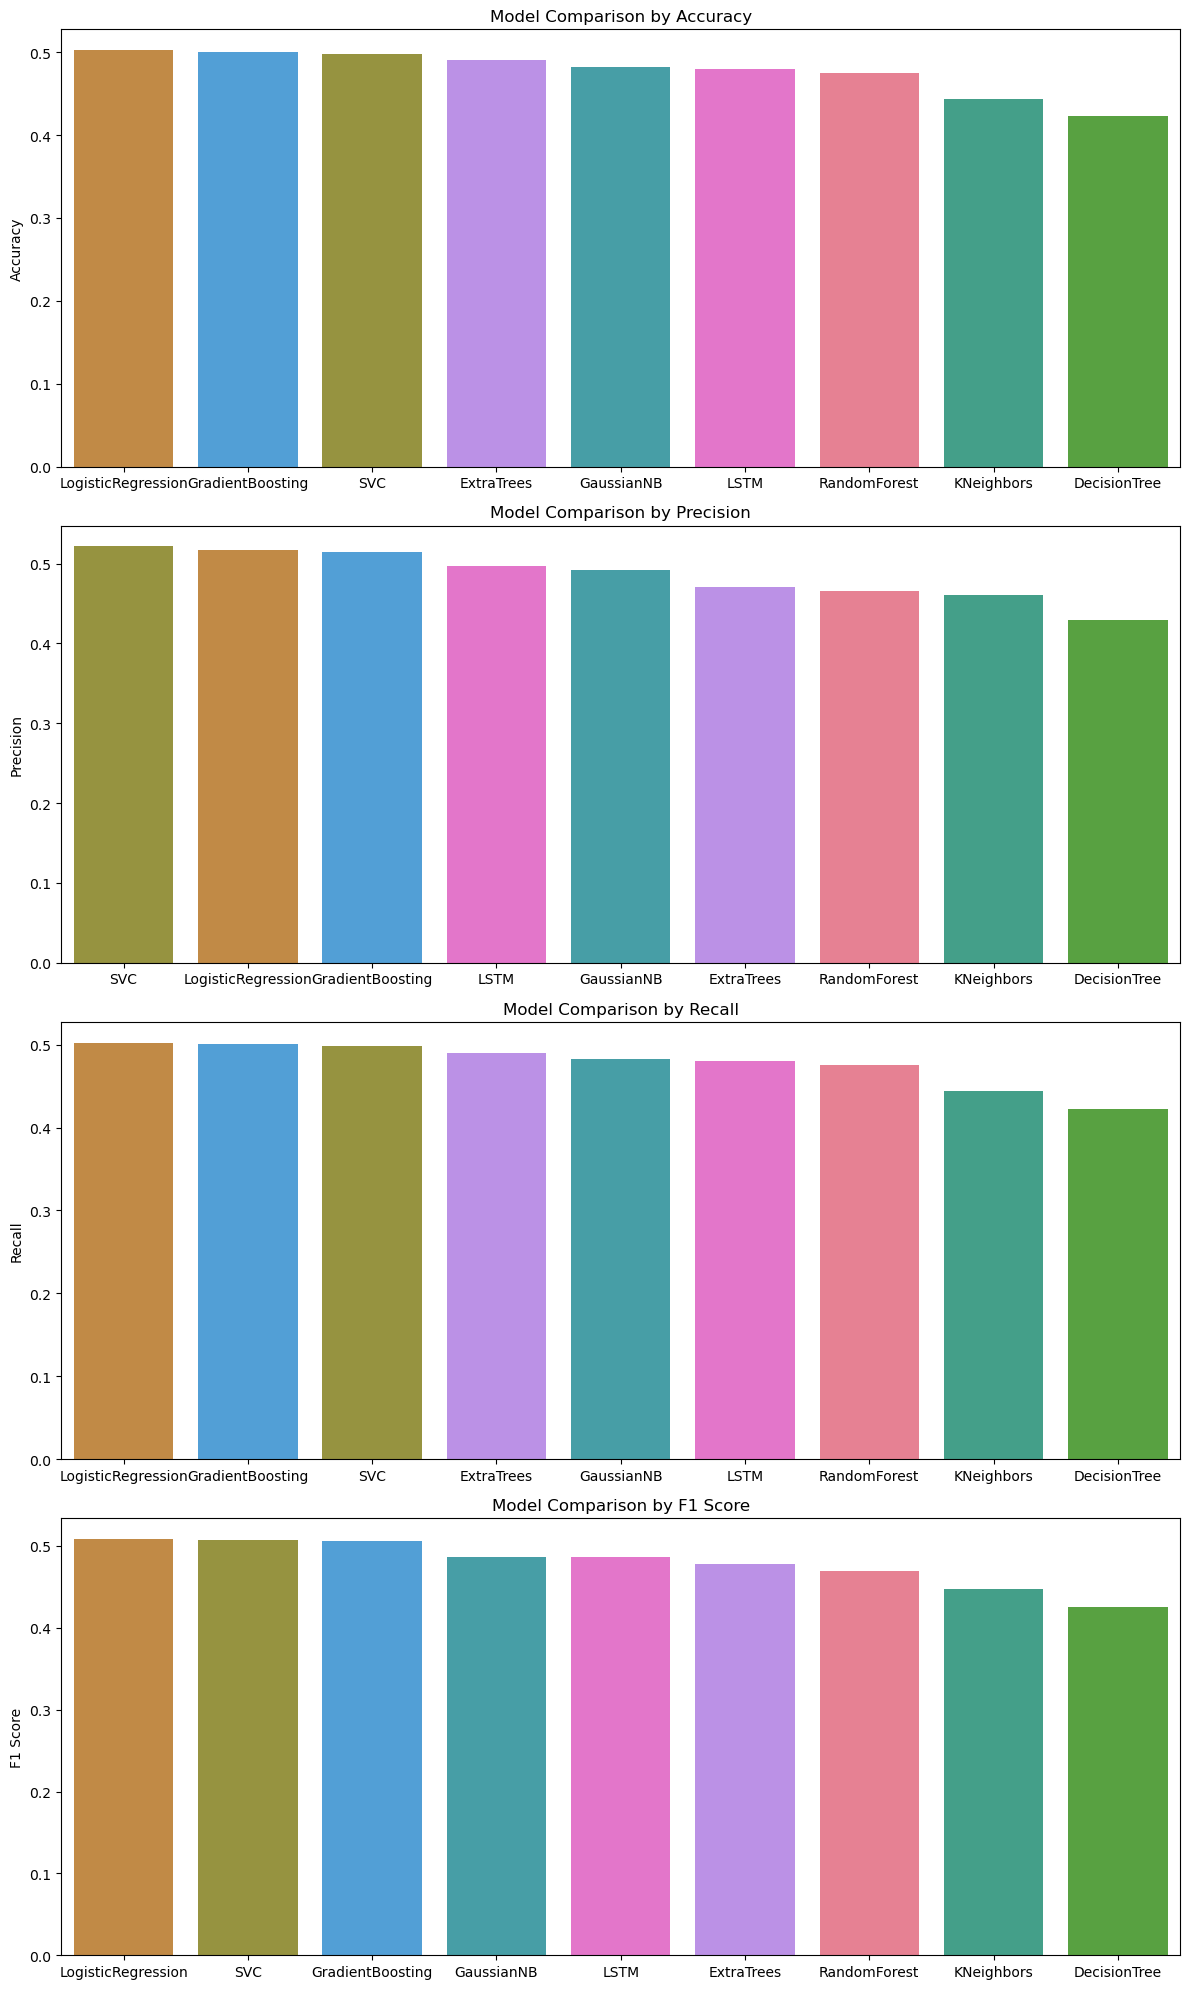

In [27]:
palette = sns.color_palette("husl", n_colors=len(all_metrics_df.index))

color_dict = dict(zip(all_metrics_df.index, palette))

fig, axes = plt.subplots(nrows=4, ncols=1, figsize=(12, 20))  # Adjust figsize as needed

# Plot each metric in its own subplot
for ax, metric in zip(axes, ['Accuracy', 'Precision', 'Recall', 'F1 Score']):
    sorted_df = all_metrics_df.sort_values(by=metric, ascending=False)
    hue_order = [name for name in sorted_df.index]

    sorted_class_names = [name.split('Classifier')[0] for name in sorted_df.index]
    sns.barplot(
        x=sorted_class_names, 
        y=sorted_df[metric],
        hue=hue_order,
        dodge=False,
        palette=color_dict,
        ax=ax
    )
    ax.get_legend().remove()
    ax.set_title(f'Model Comparison by {metric}')
    ax.set_ylabel(metric)

plt.tight_layout()
plt.show()

This seems to suggest that the 3 `best` models are:
1. `LogisticRegression`
2. `SVC`
3. `GradientBoosting`

While the 3 `worst` models are:
1. `DecisionTree`
2. `KNeighbours`
3. `RandomForest`

The deep learning `LSTM` model has average performance